In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation

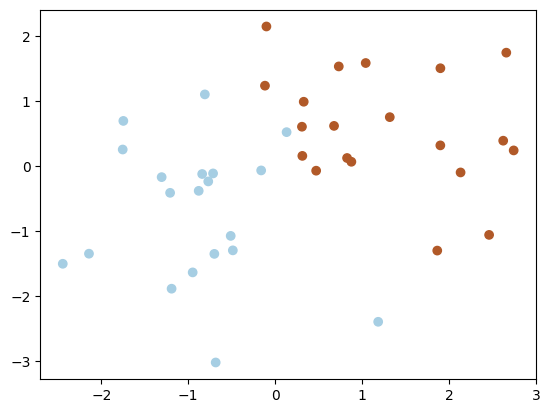

In [13]:
# 数据准备
NUM = 20
np.random.seed(1)
x1 = np.random.randn(NUM, 2) + [1, 1]
x2 = np.random.randn(NUM, 2) - [1, 1]
X = np.concatenate((x1, x2), axis=0)
Y = np.concatenate((np.ones(NUM), -np.ones(NUM)), axis=0)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

C = 1  # 惩罚系数
tol = 0.001  # 容差
max_iter = 1000  # 最大迭代次数
m, n = X.shape  # m个样本，n个特征
alpha = np.zeros(m)  # 初始化拉格朗日乘子
b = 0  # 初始化截距
iters = 0  # 初始化迭代数

In [14]:
# 核函数方程
def kernel(x, y, type="linear"):
    if type == "linear":
        result = np.dot(x, y)
    return result


# 预测值计算
def f_i(num, alpha, b, Y):
    result = np.dot(alpha * Y, kernel(X, X[num])) + b
    return result


# 预测误差计算
def Error(num, alpha, b, Y):
    result = f_i(num, alpha, b, Y) - Y[num]
    return result


# KKT误差距离计算
def KKT_error_distance(num, alpha, b, Y):
    # 如果alpha[num]等于0
    if alpha[num] == 0:
        # 计算delta
        delta = Y[num] * f_i(num, alpha, b, Y) - 1
        # 如果delta小于0，返回绝对值
        if delta < 0:
            return abs(delta)
        # 否则返回0
        else:
            return 0
    # 如果alpha[num]大于0且小于C
    elif alpha[num] > 0 and alpha[num] < C:
        # 计算delta
        delta = Y[num] * f_i(num, alpha, b, Y) - 1
        # 如果delta等于0，返回0
        if delta == 0:
            return 0
        # 否则返回绝对值
        else:
            return abs(delta)
    # 如果alpha[num]等于C
    elif alpha[num] == C:
        # 计算delta
        delta = Y[num] * f_i(num, alpha, b, Y) - 1
        # 如果delta大于0，返回绝对值
        if delta > 0:
            return abs(delta)
        # 否则返回0
        else:
            return 0

# KKT总误差计算
def KKT_error(X, alpha, b, type="max"):
    result = []
    # 计算每个样本的KKT误差距离
    for i in range(np.shape(X)[0]):
        result.append([KKT_error_distance(i, alpha, b, Y), i])
    # 将结果转换为DataFrame格式
    result = pd.DataFrame(result)
    if type == "max":
        # 按照误差距离和索引值排序
        result = result.sort_values(by=[0, 1])
        # 获取最大误差距离和对应索引
        result = [result.iloc[-1].name, result.iloc[-1].values[0]]
        return result
    if type == "list":
        return result


# eta值计算
def eta(i, j):
    result = kernel(X[i], X[i]) + kernel(X[j], X[j]) - 2 * kernel(X[i], X[j])
    return result


# 定义函数cut_off，用于计算alpha_j的值
def cut_off(alpha_old, i, j, Ei_old, Ej_old, Y):
    # 如果Y[i]不等于Y[j]，即两个样本的标签不同
    if Y[i] != Y[j]:
        # 计算L和H的值
        L = max(0, alpha_old[j] - alpha_old[i])
        H = min(C, C + alpha_old[j] - alpha_old[i])
    # 如果Y[i]等于Y[j]，即两个样本的标签相同
    else:
        # 计算L和H的值
        L = max(0, alpha_old[j] + alpha_old[i] - C)
        H = min(C, alpha_old[j] + alpha_old[i])
    # 计算alpha_j的值
    alpha_j = alpha_old[j] + Y[j] * (Ei_old - Ej_old) / eta(i, j)
    alpha_j = min(alpha_j, H)
    alpha_j = max(alpha_j, L)
    # 返回计算得到的alpha_j的值
    return alpha_j


# SVM主方程
def svm(alpha, b, X, Y, tol=0.001, C=1, max_iter=1000, is_force=False):
    iters = 0
    result = []
    # 如果is_force为True，将max_iter设置为一个很大的数，以强制迭代
    if is_force:
        max_iter = 1e10
    # 迭代直到达到最大迭代次数
    while iters < max_iter:
        for i in range(m):
            # 计算第i个样本的误差
            E1 = Error(i, alpha, b, Y)
            # 判断是否满足KKT条件
            if (Y[i] * E1 < -tol and alpha[i] < C) or (
                Y[i] * E1 > tol and alpha[i] > 0
            ):
                # 随机选择一个不等于i的样本
                j = np.random.choice([k for k in range(X.shape[0]) if k != i])
                # 计算第j个样本的误差
                E2 = Error(j, alpha, b, Y)
                # 保存alpha的旧值
                alpha_old_i = alpha[i]
                alpha_old_j = alpha[j]
                # 计算eta
                if eta(i, j) <= 0:
                    continue
                # 更新alpha[j]
                alpha[j] = cut_off(alpha, i, j, E1, E2, Y)
                # 如果alpha[j]变化很小，继续下一次循环
                if abs(alpha[j] - alpha_old_j) < 0.0001:
                    continue
                # 更新alpha[i]
                alpha[i] = alpha_old_i + Y[i] * Y[j] * (alpha_old_j - alpha[j])
                # 更新b1和b2
                b1 = (b - E1 - Y[i] * (alpha[i] - alpha_old_i) * kernel(X[i],
                      X[i]) - Y[j] * (alpha[j] - alpha_old_j) * kernel(X[i], X[j]))
                b2 = (b - E2 - Y[i] * (alpha[i] - alpha_old_i) * kernel(X[i],
                      X[j]) - Y[j] * (alpha[j] - alpha_old_j) * kernel(X[j], X[j]))
                # 更新b
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                # 更新w
                w = np.dot(alpha * Y, X)
                result.append([w, b, alpha])
        # 计算KKT误差
        KKT = KKT_error(X, alpha, b, type="max")[1]
        # 如果KKT误差小于阈值，满足KKT条件，返回结果
        if KKT < tol:
            print("KKT条件满足")
            return result
        iters += 1
    return result


# 结果可视化
def result_show(solution, X, Y):
    # 绘制数据集和决策边界
    w = solution[-1][0]
    b = solution[-1][1]
    # 绘制数据集
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # 生成网格点并预测分类
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w.T) + b
    # 绘制决策边界和支持向量
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors="k",
                levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"],)
    # 绘制支持向量
    support_vectors_1 = np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.0001)[0]
    support_vectors_2 = np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.0001)[0]
    plt.scatter(X[support_vectors_1, 0], X[support_vectors_1, 1],
                marker="o", s=100, edgecolors="k", facecolors="none")
    plt.scatter(X[support_vectors_2, 0], X[support_vectors_2, 1],
                marker="o", s=100, edgecolors="k", facecolors="none")

In [15]:
solution = svm(alpha, b, X, Y, tol=0.001, C=1, max_iter=1000, is_force=True)

KKT条件满足


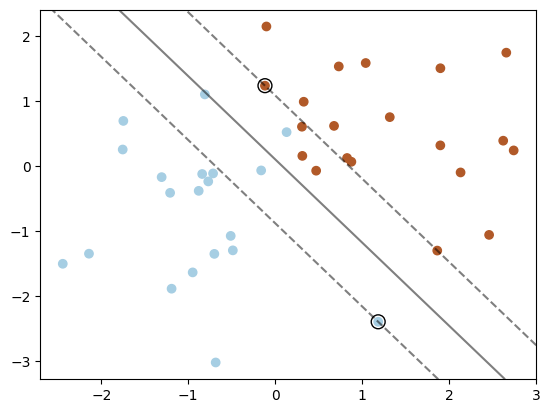

In [16]:
result_show(solution, X, Y)

In [1]:
fig, ax = plt.subplots()


def animate(i):
    ax.clear()
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
    w = solution[i][0]
    b = solution[i][1]
    k_error = KKT_error(X, solution[i][2], b, type="max")[1]
    xx = np.linspace(-5, 5, 30)
    yy = np.linspace(-5, 5, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w.T) + b
    Z = Z.reshape(XX.shape)
    ax.contour(
        XX,
        YY,
        Z,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    ax.scatter(
        X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.0001)[0], 0],
        X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.0001)[0], 1],
        marker="o",
        s=100,
        edgecolors="k",
        facecolors="none",
    )
    ax.scatter(
        X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.0001)[0], 0],
        X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.0001)[0], 1],
        marker="o",
        s=100,
        edgecolors="k",
        facecolors="none",
    )
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_title("iter: %d, KKT_error: %.4f" % (i, k_error))


anim = FuncAnimation(fig, animate, frames=len(solution), interval=15)

# 使用HTML模块将动画转换为可在Jupyter中显示的HTML
anim.save("svm.gif", fps=30)

NameError: name 'plt' is not defined

In [ ]:
# 该代码用于计算最大KKT损失以优化alpha_j的计算速度
# def inner_any(alpha_old,i,j):
#     index = np.asarray([index for index, value in enumerate(alpha)])
#     choice_index = index[(alpha < 1) & (alpha > 0)]
#     for k in choice_index:
#         if k == i:
#             continue
#         else:
#             j = k
#             result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
#             if abs(result - alpha_old[j]) < 0.0001:
#                 continue
#             else:
#                 return (result,j)
#     for k in index:
#         j = np.random.choice(index)
#         if j == i:
#             continue
#         else:
#             result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
#             if abs(result - alpha_old[j]) < 0.0001:
#                 continue
#             else:
#                 return (result,j)
#     raise Exception('No suitable j is found')

# def E_choice(num,alpha,b,type='choice'):
#     result = []
#     for i in range(np.shape(X)[0]):
#         result.append([Error(i,alpha,b),i])
#     result = pd.DataFrame(result).sort_values(by=[0,1])
#     E1 = Error(num,alpha,b)
#     if type == 'choice':
#         if E1 > 0:
#             result = [result.iloc[0].name,result.iloc[0].values[0]]
#         elif E1 < 0:
#             result = [result.iloc[-1].name,result.iloc[-1].values[0]]
#         else:
#             result = abs(result).sort_values(by=[0,1])
#             result = [result.iloc[-1].name,result.iloc[-1].values[0]]
#         return result
#     if type == 'list':
#         return result


# def choice_i_j(X,alpha,b):
#     i = KKT_error(X,alpha,b)[0]
#     j = E_choice(i,alpha,b)[0]
#     return i,j